**케라스를 사용한 인공 신경망**

# 설정

먼저 몇 개의 모듈을 임포트한다. 맷플롯립 그림을 저장하는 함수를 준비한다.

In [1]:
# 공통 모듈 임포트
import matplotlib as mpl
import os
import matplotlib.pyplot as plt

# 깔끔한 그래프 출력을 위해
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)
# 그림을 저장할 위치
PROJECT_ROOT_DIR = '.'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)


def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print(f"그림 저장: {fig_id}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 퍼셉트론

In [2]:
from sklearn.datasets import load_iris
import numpy as np
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris.target == 0).astype(int)
per_clf = Perceptron(n_jobs=-1)
per_clf.fit(X, y)
y_pred = per_clf.predict([[2, 0.5]])

In [3]:
y_pred

array([0])

그림 저장: perceptron_iris_plot


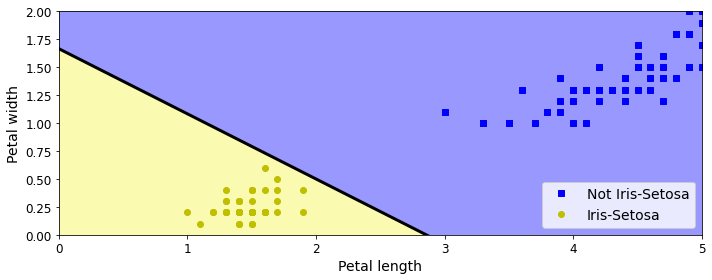

In [4]:
from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1), np.linspace(axes[2], axes[3], 200).reshape(-1, 1)
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
plt.figure(figsize=(10, 4))
plt.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris-Setosa")
plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
custom_cmap = ListedColormap(["#9898ff", "#fafab0"])
plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)
save_fig("perceptron_iris_plot")
plt.show()

# 활성화 함수

In [20]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def relu(z):
    return np.maximum(0, z)


def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps)) / (2 * eps)

그림 저장: activation_functions_plot


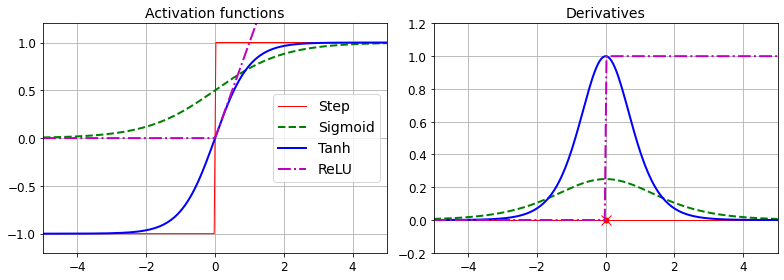

In [21]:
z = np.linspace(-5, 5, 200)
plt.figure(figsize=(11, 4))
plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])
plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])
save_fig("activation_functions_plot")
plt.show()